In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
import sys 
sys.path.insert(0, '../src/')

import warnings; warnings.simplefilter('ignore')
import emcee
import corner
from multiprocess import Pool
import time
import galhalo
import mcmc_aux

import jsm_prephalo, jsm_stats
from scipy.stats import ks_2samp, chi2, combine_pvalues

In [75]:
# file = "../../data/3000_12_8/acc_surv_mass.npy"

# massmat = jsm_prephalo.MassMat(file, phimin=-4) #grab the data
# massmat.prep_data(includenan=False)

# massmat.SAGA_break(Nsamp=100)  #make the SAGA sets

# np.save("../../data/MCMC/SAGA_samples.npy", massmat.lgMh_mat)

creating the data sample

In [76]:
lgMh_mat = np.load("../../data/MCMC/SAGA_samples.npy")

alpha, delta, sigma = 1.9, 0.3, 0.5

lgMs_mat = galhalo.SHMR(lgMh_mat, alpha, delta, sigma)

In [77]:
stat = jsm_stats.SatStats(lgMs_mat)

stat.satfreq(6.5)

stat.maxsatmass()


Using the full sample to define truth and the error bars

In [99]:
# np.save("../../data/MCMC/error_CDF.npy", np.std(stat.satfreq_CDF_mat, axis=0))

# np.save("../../data/MCMC/error_PDF.npy", np.std(stat.satfreq_PDF_mat, axis=0))

mock_index = 2 # need to exclude this set

stat.maxsatmass.shape


AttributeError: 'function' object has no attribute 'shape'

In [ ]:

data_CDF = stat.maxsatmass_CDF_mat[truth_index]

data_PDF = stat.satfreq_PDF_mat[truth_index]

error_CDF = np.std(stat.maxsatmass_CDF_mat, axis=0)

error_PDF = np.std(stat.satfreq_PDF_mat, axis=0)

<ErrorbarContainer object of 3 artists>

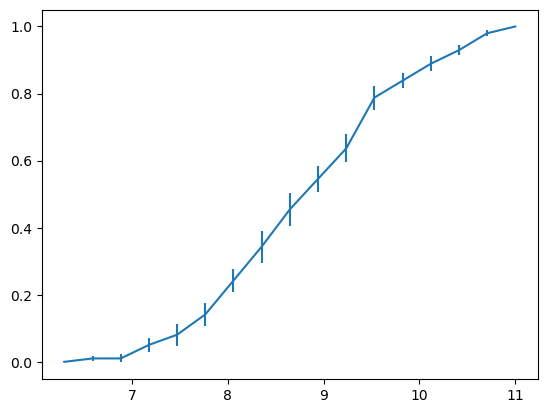

In [80]:
plt.errorbar(stat.maxsatmass_bins[1:], data_CDF, yerr=error_CDF) 

<ErrorbarContainer object of 3 artists>

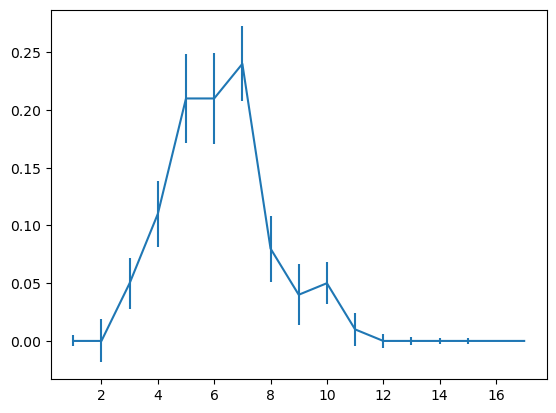

In [81]:
plt.errorbar(stat.satfreq_bins[1:], data_PDF, yerr=error_PDF) 

Now picking one set to run the MCMC on

In [82]:
mock_index = 2

#np.save("../../data/MCMC/mock_lgMh.npy", lgMh_mat[mock_index])

mock_lgMh = lgMh_mat[mock_index]

writing the out the model

In [83]:
def forward(theta):

    alpha, delta, sigma = theta #inputting the parameters
    lgMs = galhalo.SHMR(mock_lgMh, alpha, delta, sigma)

    satfreq = jsm_stats.satfreq(lgMs, 6.5)
    maxsatmass = jsm_stats.maxsatmass(lgMs)

    return satfreq, maxsatmass

In [84]:
# combine_pvalues((0.5, 0.05))[1]

# p_value_satfreq = chi2.sf(chisquare_satfreq, 17)
# p_value_maxsatmass = chi2.sf(chisquare_maxsatmass, 17)
# p_value_comb = combine_pvalues([p_value_maxsatmass, p_value_satfreq])[0]

# print(np.log([1-p_value_satfreq, 1-p_value_maxsatmass, 1-p_value_comb]))

now working on the likelyhoods

In [85]:
def lnlike(theta):
    satfreq, maxsatmass = forward(theta)
    chisquare_satfreq = np.nansum( (satfreq - data_PDF)**2/error_PDF**2 )
    chisquare_maxsatmass = np.nansum( ((maxsatmass - data_CDF)/error_CDF)**2 )  

    return -2*chisquare_maxsatmass + -2*chisquare_satfreq

In [86]:
def lnprior(theta):
    alpha, delta, sigma = theta
    if 0.5 < alpha < 3.5 and -0.5 < delta < 3.5 and 0 < sigma < 4:
        return 0.0
    else:
        return -np.inf

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta)

In [87]:
# alphas = np.linspace(1.6, 3.4, 10)

# deltas = np.linspace(-0.2, 2.9, 10)

# sigmas = np.linspace(0.1, 3.9, 10)

# for i in alphas:
#     for j in deltas:
#         for k in sigmas:
#             lnlike([i,j,k])

In [93]:
def MCMC_RUN(theta_0, lnprob, nwalkers=1000, niter=5000, ndim=3, ncores=8, converge=False):

    p0 = [np.array(theta_0) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
    
    with Pool(ncores) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
        start = time.time()
        sampler.run_mcmc(p0, niter)
        end = time.time()
        multi_time = end - start
        print("Run took {0:.1f} seconds".format(multi_time))

    if converge==True:
        tau = sampler.get_autocorr_time()
        print('$\\alpha$ took', tau[0], 'steps')
        print('$\\delta$ took', tau[1], 'steps')
        print('$\\sigma$ took', tau[2], 'steps')

    return sampler

In [94]:
start_theta = [1, 1, 1]

mcmc_out = MCMC_RUN(start_theta, lnprob)

run = mcmc_aux.inspect_run(mcmc_out, fid_theta=[alpha, delta, sigma])

Run took 389.9 seconds


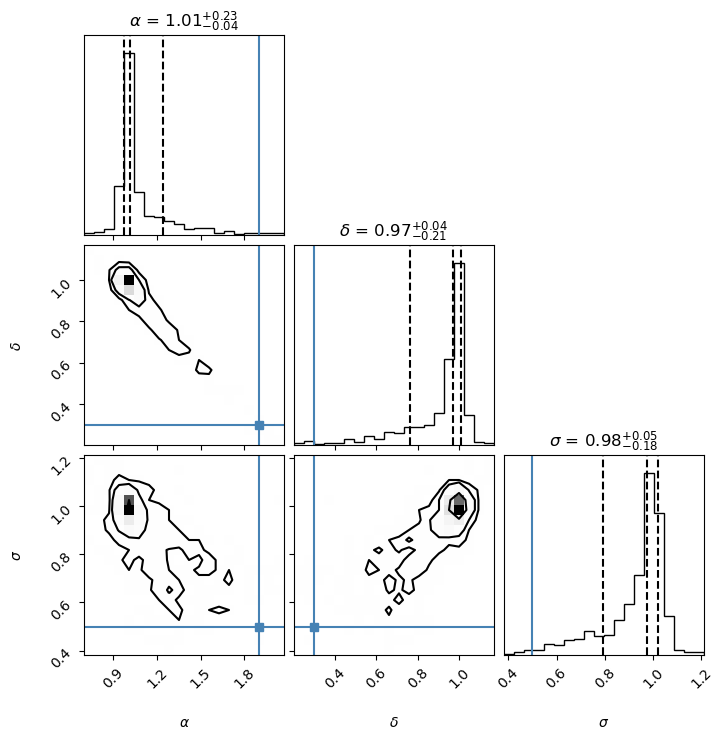

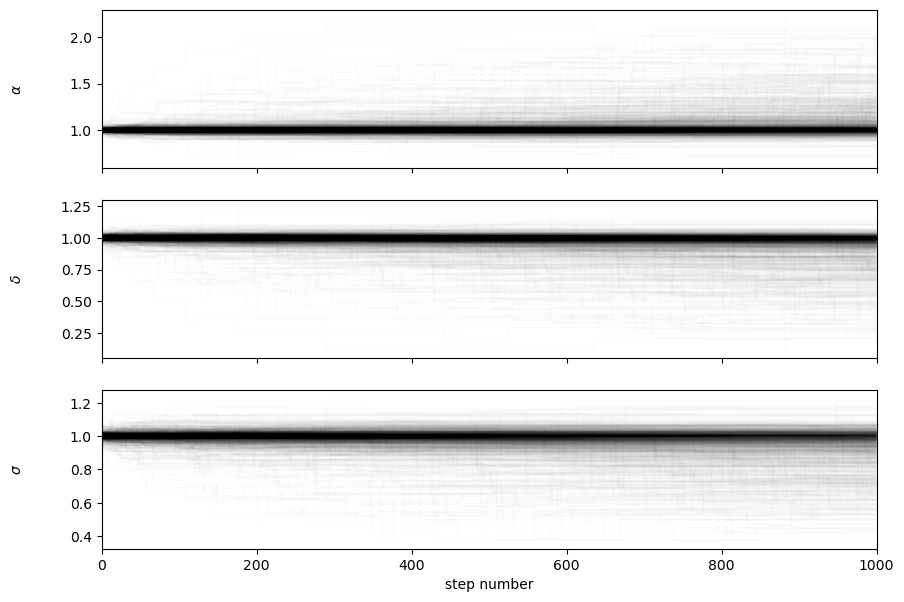

not normalizing for the upscatter


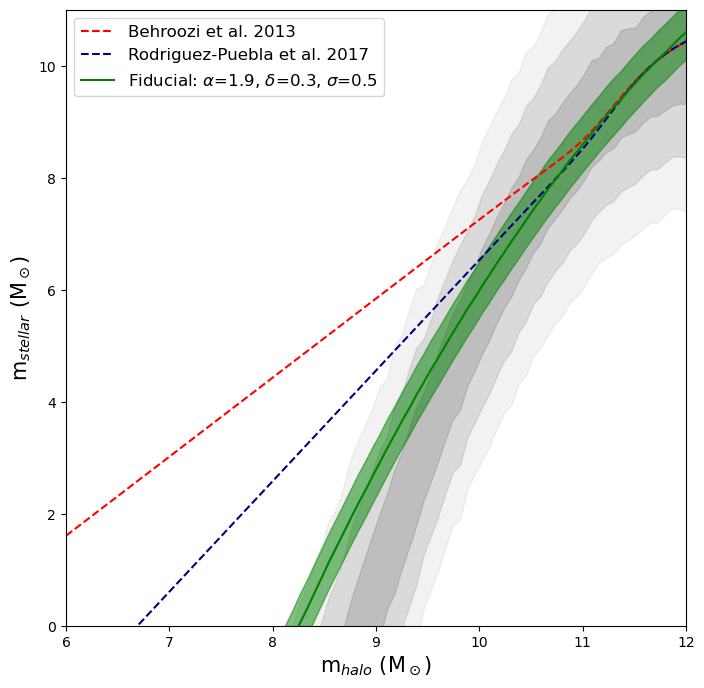

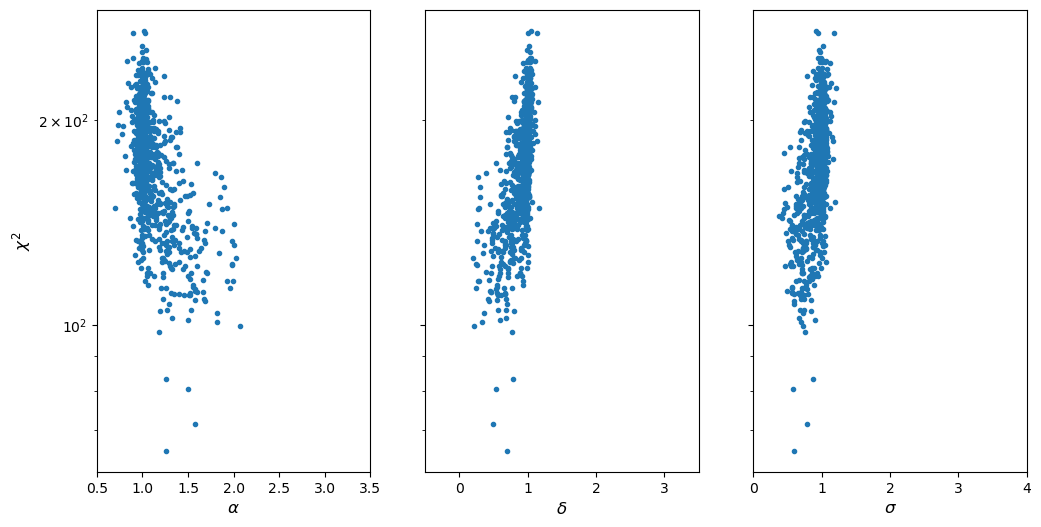

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[[1.0144978960256719, 0.04021673017074323, 0.22955969659863995],
 [0.9722286744967905, 0.20797080755165764, 0.038739339611917556],
 [0.9768068498050149, 0.1827535317200495, 0.0457171748295746]]

In [92]:
run.corner_plot(zoom=True)
run.chain_plot()
run.SHMR_plot()
run.chi_square_plot()
run.best_fit_values()
#vals.append(val_i)

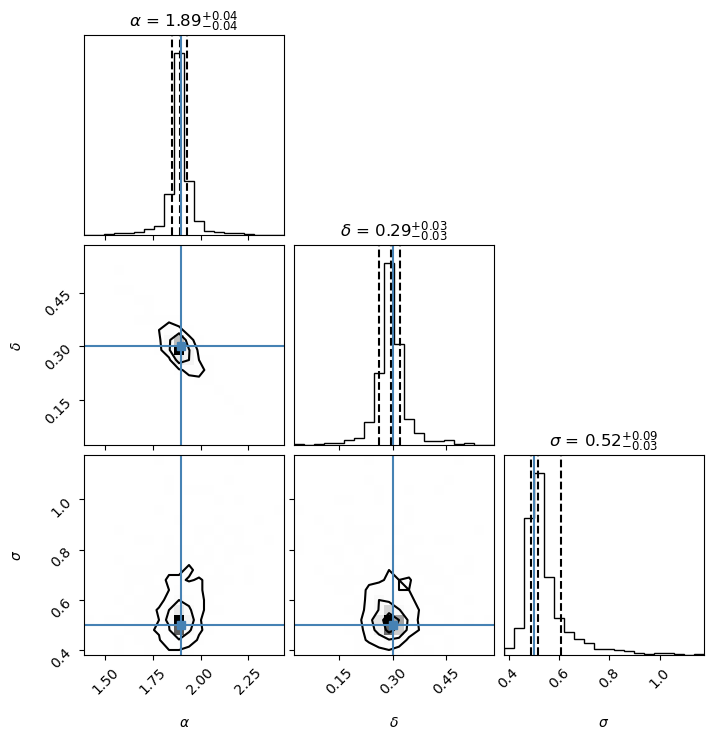

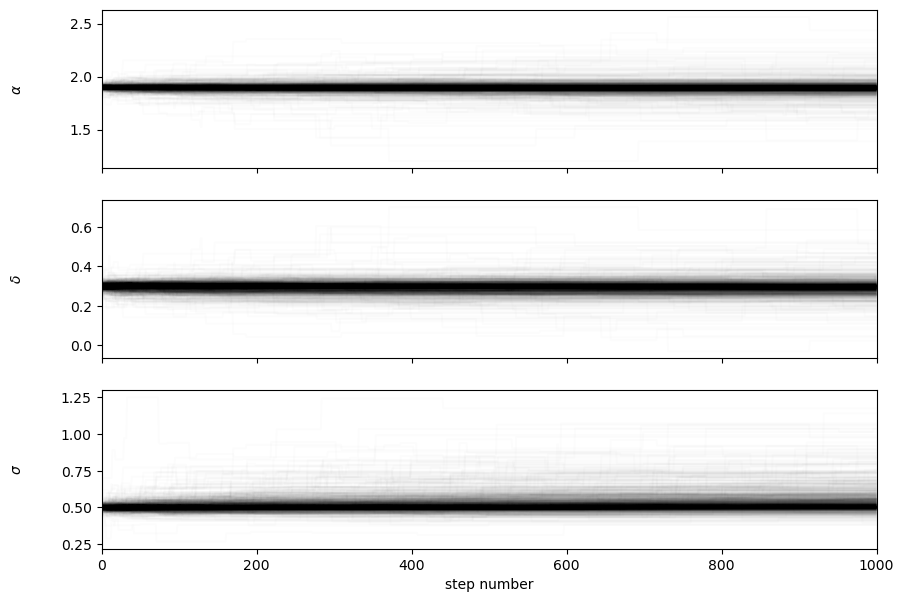

not normalizing for the upscatter


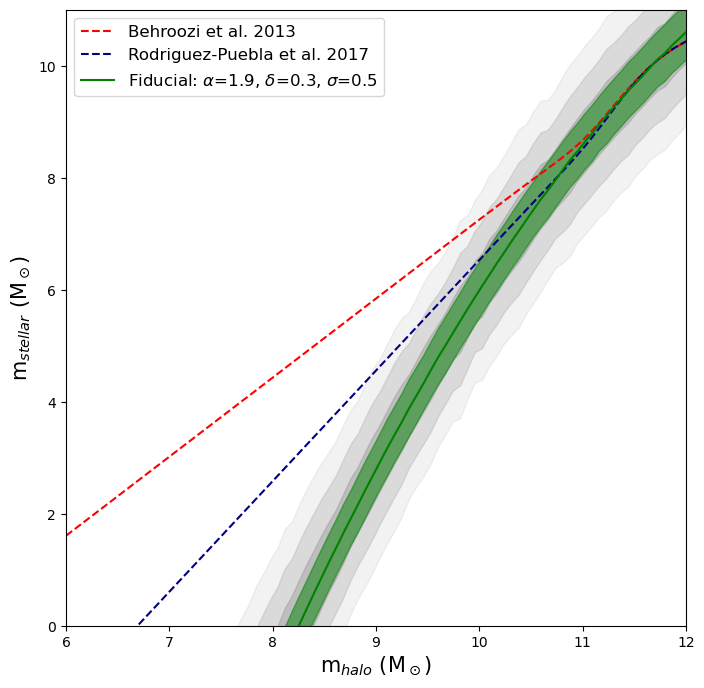

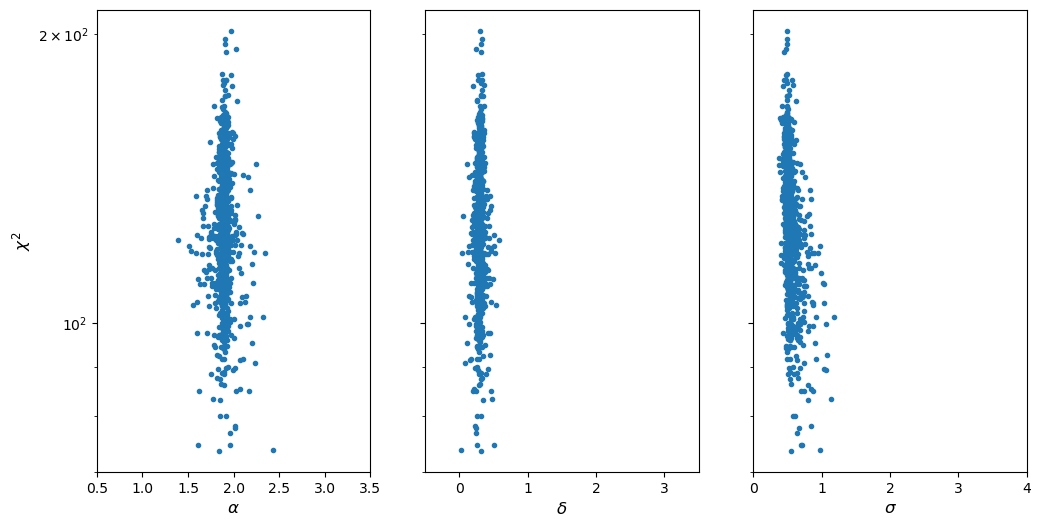

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[[1.8937373034708516, 0.0420732134647932, 0.03629222779382868],
 [0.2934306470298437, 0.03288470797461429, 0.02736113864931289],
 [0.5182855459706132, 0.030857623772825027, 0.09123802386678892]]

In [90]:
run.corner_plot(zoom=True)
run.chain_plot()
run.SHMR_plot()
run.chi_square_plot()
run.best_fit_values()
#vals.append(val_i)